In [1]:
# Step 1: Load and preprocess data
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data.encoders import NaNLabelEncoder, GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from itertools import product

c:\Users\sanja\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_forecasting\models\base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [10]:


# Load and preprocess data
data = pd.read_csv('D:/MAC-Course/Sem 2/ADT/Final Project/Predicting_Canadian_Job_Vacancies-main/Predicting_Canadian_Job_Vacancies-main/Database/Resources/MachineLearning.csv')
data['ref_date'] = pd.to_datetime(data['ref_date'], format='%m-%d-%Y')

# Remove existing 'Canada' entries
data = data[data['geo'] != 'Canada']

# Aggregate total vacancies over provinces to compute 'Canada' totals
canada_totals = data.groupby(['ref_date', 'noc_desc', 'job_char'], as_index=False)['total_vacancies'].sum()

# Add 'geo' column with value 'Canada'
canada_totals['geo'] = 'Canada'

# Append 'Canada' totals back into the data
data = pd.concat([data, canada_totals], ignore_index=True)

# Now proceed with filtering data for training (2015-2022) and future prediction (2023-2024)
train_data = data[(data['ref_date'] >= '2019-01-01') & (data['ref_date'] <= '2022-12-31')]
future_data = data[(data['ref_date'] >= '2023-01-01') & (data['ref_date'] <= '2024-12-31')]
# Extend future data for years 2025-2027
future_dates = pd.date_range(start="2025-01-01", end="2027-12-31", freq="QS")  # Quarterly Start

future_data 


,idML,ref_date,geo,noc_code,noc_desc,job_char,total_vacancies
7932,46138232.0,2023-01-01,Newfoundland and Labrador,101.0,"Total, all occupations","Type of work, all types",5795
7933,46138235.0,2023-01-01,Newfoundland and Labrador,101.0,"Total, all occupations",Full-time,4695
7934,46138238.0,2023-01-01,Newfoundland and Labrador,101.0,"Total, all occupations",Part-time,1095
7935,46139695.0,2023-01-01,Newfoundland and Labrador,1.0,"Business, finance and administration occupations","Type of work, all types",780
7936,46139698.0,2023-01-01,Newfoundland and Labrador,1.0,"Business, finance and administration occupations",Full-time,710
...,...,...,...,...,...,...,...
10708,NaN,2024-01-04,Canada,NaN,"Total, all occupations",Part-time,152495
10709,NaN,2024-01-04,Canada,NaN,"Total, all occupations","Type of work, all types",621080
10710,NaN,2024-01-04,Canada,NaN,"Trades, transport and equipment operators and ...",Full-time,105530
10711,NaN,2024-01-04,Canada,NaN,"Trades, transport and equipment operators and ...",Part-time,8695


In [11]:
# Print the number of rows in the training and future data
print(f"Number of rows in training data: {len(train_data)}")
print(f"Number of rows in future data: {len(future_data)}")

# Check unique provinces in the training data
print(f"Unique provinces in training data: {train_data['geo'].unique()}")

# Check unique provinces in the future data
print(f"Unique provinces in future data: {future_data['geo'].unique()}")


Number of rows in training data: 4364
Number of rows in future data: 1847
Unique provinces in training data: ['Newfoundland and Labrador' 'Prince Edward Island' 'Nova Scotia'
 'New Brunswick' 'Quebec' 'Ontario' 'Manitoba' 'Saskatchewan' 'Alberta'
 'British Columbia' 'Yukon' 'Northwest Territories' 'Nunavut' 'Canada']
Unique provinces in future data: ['Newfoundland and Labrador' 'Prince Edward Island' 'Nova Scotia'
 'New Brunswick' 'Quebec' 'Ontario' 'Manitoba' 'Saskatchewan' 'Alberta'
 'British Columbia' 'Yukon' 'Northwest Territories' 'Nunavut' 'Canada']


In [12]:
# Check for missing values in the future data
print(f"Missing values in future data:\n{future_data.isnull().sum()}")

# Check the date range in the future data
print(f"Date range in future data: {future_data['ref_date'].min()} to {future_data['ref_date'].max()}")

# Check unique combinations of geo, noc_desc, and job_char in training data
train_combinations = train_data[['geo', 'noc_desc', 'job_char']].drop_duplicates()
print(f"Unique combinations in training data: {len(train_combinations)}")

# Check unique combinations of geo, noc_desc, and job_char in future data
future_combinations = future_data[['geo', 'noc_desc', 'job_char']].drop_duplicates()
print(f"Unique combinations in future data: {len(future_combinations)}")
# Find missing combinations in future data
missing_combinations = pd.merge(train_combinations, future_combinations, on=['geo', 'noc_desc', 'job_char'], how='left', indicator=True)
missing_combinations = missing_combinations[missing_combinations['_merge'] == 'left_only']
print(f"Missing combinations in future data:\n{missing_combinations}")


Missing values in future data:
idML               190
ref_date             0
geo                  0
noc_code           190
noc_desc             0
job_char             0
total_vacancies      0
dtype: int64
Date range in future data: 2023-01-01 00:00:00 to 2024-01-04 00:00:00
Unique combinations in training data: 402
Unique combinations in future data: 368
Missing combinations in future data:
                       geo                                           noc_desc  \
77           New Brunswick         Occupations in manufacturing and utilities   
104                 Quebec  Natural resources, agriculture and related pro...   
113                Ontario      Legislative and senior management occupations   
145               Manitoba      Legislative and senior management occupations   
165               Manitoba         Occupations in manufacturing and utilities   
252                  Yukon                                 Health occupations   
263  Northwest Territories             

In [13]:
# Generate all combinations of geo, noc_desc, and job_char for future dates
geo_values = train_data['geo'].unique()
noc_desc_values = train_data['noc_desc'].unique()
job_char_values = train_data['job_char'].unique()

future_combinations = pd.DataFrame(
    list(product(future_dates, geo_values, noc_desc_values, job_char_values)),
    columns=["ref_date", "geo", "noc_desc", "job_char"]
)

In [14]:
# Add placeholder for total_vacancies in the extended future data
future_combinations['total_vacancies'] = None

# Combine with existing future data
future_data = pd.concat([future_data, future_combinations], ignore_index=True)


In [15]:
# Print the number of rows in the training and future data
print(f"Number of rows in training data: {len(train_data)}")
print(f"Number of rows in future data (2023-2027): {len(future_data)}")


Number of rows in training data: 4364
Number of rows in future data (2023-2027): 7391


In [16]:
# Fit the scaler on the entire `total_vacancies` column to ensure all ranges are covered.
scaler = MinMaxScaler()
scaler.fit(data[['total_vacancies']])

# Apply scaling to train and future data
train_data['total_vacancies_scaled'] = scaler.transform(train_data[['total_vacancies']])
future_data['total_vacancies_scaled'] = scaler.transform(future_data[['total_vacancies']].fillna(0))  # Replace NaNs with 0 for scaling

# Encode categorical columns
geo_encoder = NaNLabelEncoder()
sector_encoder = NaNLabelEncoder()
job_char_encoder = NaNLabelEncoder()

train_data['geo_encoded'] = geo_encoder.fit_transform(train_data['geo'])
train_data['noc_desc_encoded'] = sector_encoder.fit_transform(train_data['noc_desc'])
train_data['job_char_encoded'] = job_char_encoder.fit_transform(train_data['job_char'])

future_data['geo_encoded'] = geo_encoder.transform(future_data['geo'])
future_data['noc_desc_encoded'] = sector_encoder.transform(future_data['noc_desc'])
future_data['job_char_encoded'] = job_char_encoder.transform(future_data['job_char'])

# Create a time index
train_data['time_idx'] = (train_data['ref_date'] - train_data['ref_date'].min()).dt.days
future_data['time_idx'] = (future_data['ref_date'] - train_data['ref_date'].min()).dt.days


C:\Users\sanja\AppData\Local\Temp\ipykernel_22552\3534478187.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['total_vacancies_scaled'] = scaler.transform(train_data[['total_vacancies']])
C:\Users\sanja\AppData\Local\Temp\ipykernel_22552\3534478187.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future_data['total_vacancies_scaled'] = scaler.transform(future_data[['total_vacancies']].fillna(0))  # Replace NaNs with 0 for scaling
C:\Users\sanja\AppData\Local\Temp\ipykernel_22552\3534478187.py:14: SettingWithCopyWa

In [17]:
# Identify outliers using the interquartile range (IQR)
q1 = train_data['total_vacancies'].quantile(0.25)
q3 = train_data['total_vacancies'].quantile(0.75)
iqr = q3 - q1

# Define acceptable range
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out outliers
train_data = train_data[(train_data['total_vacancies'] >= lower_bound) & (train_data['total_vacancies'] <= upper_bound)]


In [18]:

# Define TimeSeriesDataSet
max_encoder_length = 120
max_prediction_length = 30

train_dataset = TimeSeriesDataSet(
    train_data,
    time_idx="time_idx",
    target="total_vacancies_scaled",
    group_ids=["geo_encoded", "noc_desc_encoded", "job_char_encoded"],
    min_encoder_length=1,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["geo", "noc_desc", "job_char"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["total_vacancies_scaled"],
    categorical_encoders={
        "geo_encoded": NaNLabelEncoder(),
        "noc_desc_encoded": NaNLabelEncoder(),
        "job_char_encoded": NaNLabelEncoder()
    },
    target_normalizer=GroupNormalizer(groups=["geo_encoded", "noc_desc_encoded", "job_char_encoded"]),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
)

c:\Users\sanja\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_forecasting\data\timeseries.py:1301: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 55 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__geo_encoded': 0, '__group_id__noc_desc_encoded': 4, '__group_id__job_char_encoded': 1}, {'__group_id__geo_encoded': 0, '__group_id__noc_desc_encoded': 7, '__group_id__job_char_encoded': 1}, {'__group_id__geo_encoded': 1, '__group_id__noc_desc_encoded': 2, '__group_id__job_char_encoded': 1}, {'__group_id__geo_encoded': 1, '__group_id__noc_desc_encoded': 3, '__group_id__job_char_encoded': 1}, {'__group_id__geo_encoded': 1, '__group_id__noc_desc_encoded': 4, '__group_id__job_char_encoded': 1}, {'__group_id__geo_encoded': 1, '__group_id__noc_desc_encoded': 7, '__group_id__job_char_encoded': 1}, 

In [19]:
# Print the number of rows in the train_dataset
print(f"Number of rows in train_dataset: {len(train_dataset.data)}")


Number of rows in train_dataset: 6


In [22]:
# Create DataLoaders
train_loader = train_dataset.to_dataloader(train=True, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)
val_loader = train_dataset.to_dataloader(train=False, batch_size=64, num_workers=4, persistent_workers=True)


In [23]:
train_loader
val_loader

In [21]:

from pytorch_lightning import LightningModule



# Define and train Temporal Fusion Transformer
class TFTModule(LightningModule):
	def __init__(self, tft):
		super().__init__()
		self.tft = tft

	def forward(self, x):
		y_pred = self.tft(x)
		# Ensure y_pred has the correct shape
		if isinstance(y_pred, tuple):
			y_pred = y_pred[0]
		return y_pred

	def training_step(self, batch, batch_idx):
		x, y = batch
		y_hat = self(x)
		loss = self.tft.loss(y_hat, y)
		self.log("train_loss", loss)
		return loss

	def validation_step(self, batch, batch_idx):
		x, y = batch
		y_hat = self(x)
		loss = self.tft.loss(y_hat, y)
		self.log("val_loss", loss)
		return loss

	def configure_optimizers(self):
		return torch.optim.Adam(self.parameters(), lr=0.03)


tft = TFTModule(TemporalFusionTransformer.from_dataset(
	train_dataset,
	learning_rate=0.001,
	hidden_size=64,
	attention_head_size=8,
	dropout=0.1,
	hidden_continuous_size=32,
	output_size=len(QuantileLoss().quantiles),  # QuantileLoss output size
	loss=QuantileLoss(),
	optimizer="adam",
	log_interval=10
))

early_stop_callback = EarlyStopping(monitor="val_loss", patience=10, verbose=True, mode="min", min_delta=1e-4)
trainer = Trainer(
	max_epochs=100,  # Increased number of epochs
	accelerator="cpu",
	devices=1,
	callbacks=[early_stop_callback]
)


trainer.fit(tft, train_dataloaders=train_loader, val_dataloaders=val_loader)



c:\Users\sanja\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\sanja\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name | Type                      | Params | Mode 
-----------------------------------------------------------
0 | tft  | TemporalFusionTransformer | 262 K  | train
-----------------------------------------------------------
262 K     Trainable params
0         Non-trainable params
262 K     Total params
1.050     Total estimated model params size (MB)
303       Modules in train mode
0         Modules in eval mode


c:\Users\sanja\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 0: 100%|██████████| 73/73 [00:08<00:00,  8.62it/s, v_num=164]

c:\Users\sanja\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 35. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
Metric val_loss improved. New best score: 0.001


Epoch 6: 100%|██████████| 73/73 [00:08<00:00,  8.14it/s, v_num=164]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.001


Epoch 16: 100%|██████████| 73/73 [00:08<00:00,  8.74it/s, v_num=164]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.


Epoch 16: 100%|██████████| 73/73 [00:08<00:00,  8.68it/s, v_num=164]


In [24]:

# Prepare future data for prediction
combined_data = pd.concat([train_data, future_data]).drop_duplicates(subset=['time_idx', 'geo_encoded', 'noc_desc_encoded', 'job_char_encoded'])
combined_data.reset_index(drop=True, inplace=True)

# Fill missing values in total_vacancies_scaled with the mean of the column
combined_data['total_vacancies_scaled'].fillna(combined_data['total_vacancies_scaled'].mean(), inplace=True)

combined_dataset = TimeSeriesDataSet.from_dataset(train_dataset, combined_data)
dataloader = combined_dataset.to_dataloader(train=False, batch_size=64)

C:\Users\sanja\AppData\Local\Temp\ipykernel_22552\2098269465.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data['total_vacancies_scaled'].fillna(combined_data['total_vacancies_scaled'].mean(), inplace=True)


In [25]:
# Make predictions
predictions = tft.tft.predict(dataloader,mode="quantiles", return_x=False)
print(f"Prediction quantiles:\n{predictions}")


c:\Users\sanja\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=17` in the `DataLoader` to improve performance.


Prediction quantiles:
tensor([[[ 4.2942e-03,  5.2022e-03,  5.5636e-03,  ...,  5.9820e-03,
           6.1102e-03,  6.8889e-03],
         [ 4.1715e-03,  5.1800e-03,  5.5970e-03,  ...,  6.1222e-03,
           6.3205e-03,  7.1648e-03],
         [ 4.1715e-03,  5.1750e-03,  5.6127e-03,  ...,  6.2051e-03,
           6.4569e-03,  7.3092e-03],
         ...,
         [        nan,         nan,         nan,  ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan,  ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan,  ...,         nan,
                  nan,         nan]],

        [[ 4.2928e-03,  5.2031e-03,  5.5655e-03,  ...,  5.9844e-03,
           6.1131e-03,  6.8937e-03],
         [ 4.1687e-03,  5.1789e-03,  5.5970e-03,  ...,  6.1248e-03,
           6.3251e-03,  7.1725e-03],
         [ 4.1709e-03,  5.1748e-03,  5.6126e-03,  ...,  6.2055e-03,
           6.4573e-03,  7.3100e-03],
         ...,
   

In [26]:
# Denormalize the predicted vacancies
predicted_vacancies = predictions.numpy().flatten().reshape(-1, 1)
denormalized_vacancies = scaler.inverse_transform(predicted_vacancies).flatten()

In [27]:
# Ensure the lengths of the arrays match
min_length = min(len(future_data['ref_date']), len(denormalized_vacancies))

In [ ]:
# Save results
results = pd.DataFrame({
    "ref_date": future_data['ref_date'][:min_length],
    "geo": geo_encoder.inverse_transform(future_data['geo_encoded'][:min_length]),
    "noc_desc": sector_encoder.inverse_transform(future_data['noc_desc_encoded'][:min_length]),
    "job_char": job_char_encoder.inverse_transform(future_data['job_char_encoded'][:min_length]),
    "predicted_vacancies": denormalized_vacancies[:min_length]
})
results['predicted_vacancies'] = results['predicted_vacancies'].fillna(method='bfill').fillna(method='ffill')

results.to_csv("Predictions.csv", index=False)
print("Predictions saved to 'Predictions.csv'.")

Predictions saved to 'Predictions.csv'.


C:\Users\sanja\AppData\Local\Temp\ipykernel_22552\3568430511.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  results['predicted_vacancies'] = results['predicted_vacancies'].fillna(method='bfill').fillna(method='ffill')


In [38]:
# Convert 'ref_date' to datetime for easier plotting
predictions_df = pd.read_csv('./Predictions.csv')
predictions_df['ref_date'] = pd.to_datetime(predictions_df['ref_date'])


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


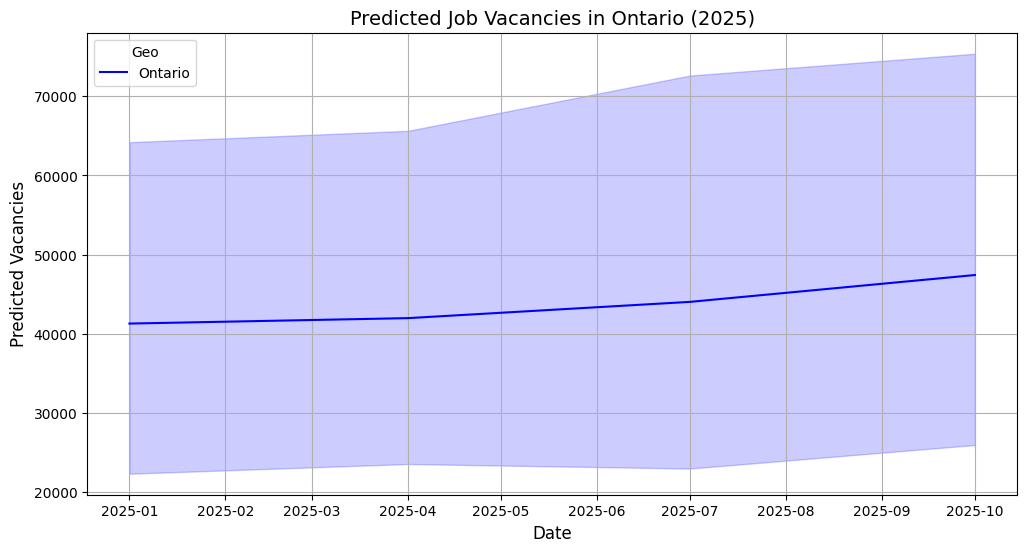

In [51]:
# Filter the dataset for Ontario and 2025
ontario_data = predictions_df[
    (predictions_df['ref_date'].dt.year == 2025) & 
    (predictions_df['geo'] == 'Ontario')
]

# Visualization: Line plot for Ontario predictions in 2025
plt.figure(figsize=(12, 6))
sns.lineplot(data=ontario_data, x='ref_date', y='predicted_total_vacancies', label='Ontario', color='blue')

plt.title('Predicted Job Vacancies in Ontario (2025)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Predicted Vacancies', fontsize=12)
plt.legend(title='Geo', loc='upper left', fontsize=10)
plt.grid()
plt.show()


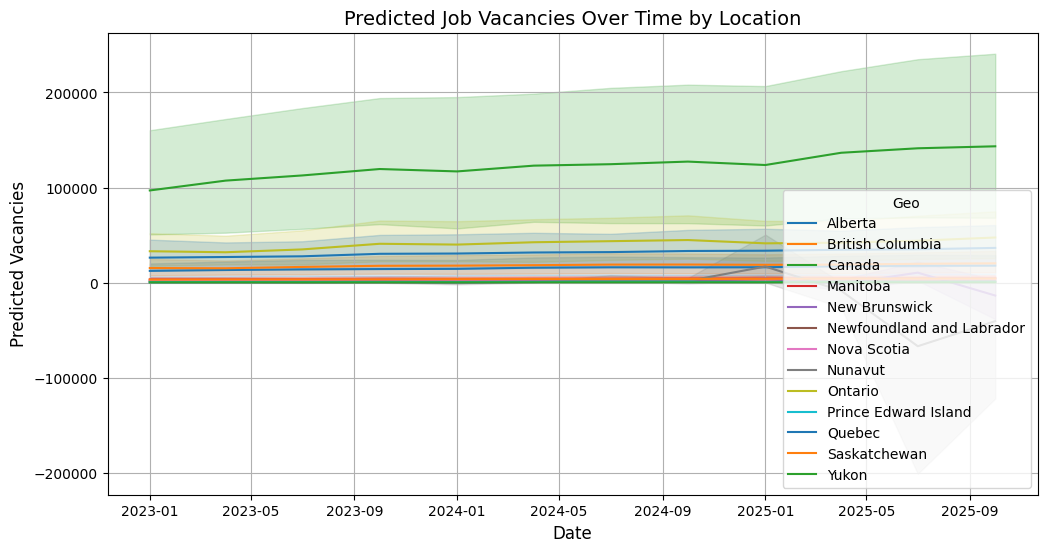

In [46]:
# Visualization 1: Line plot for trends of predicted vacancies over time
plt.figure(figsize=(12, 6))
for geo in predictions_df['geo'].unique():
    subset = predictions_df[predictions_df['geo'] == geo]
    sns.lineplot(data=subset, x='ref_date', y='predicted_total_vacancies', label=geo)

plt.title('Predicted Job Vacancies Over Time by Location', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Predicted Vacancies', fontsize=12)
plt.legend(title='Geo')
plt.grid()
plt.show()

C:\Users\sanja\AppData\Local\Temp\ipykernel_22552\2328991040.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=geo_sums.index, y=geo_sums.values, palette='viridis')


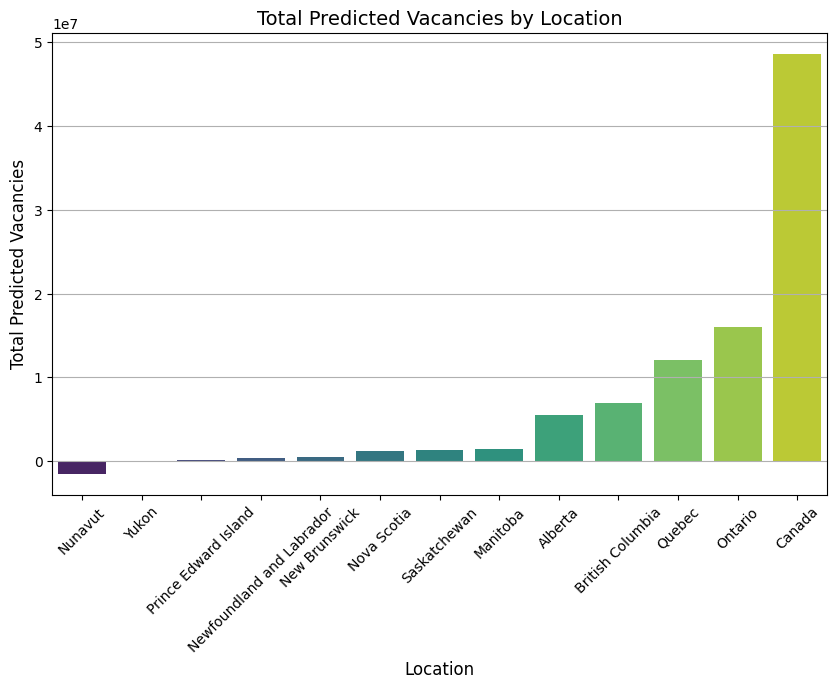

In [41]:
# Visualization 2: Bar plot of total predicted vacancies per location
plt.figure(figsize=(10, 6))
geo_sums = predictions_df.groupby('geo')['predicted_total_vacancies'].sum().sort_values()
sns.barplot(x=geo_sums.index, y=geo_sums.values, palette='viridis')

plt.title('Total Predicted Vacancies by Location', fontsize=14)
plt.xlabel('Location', fontsize=12)
plt.ylabel('Total Predicted Vacancies', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

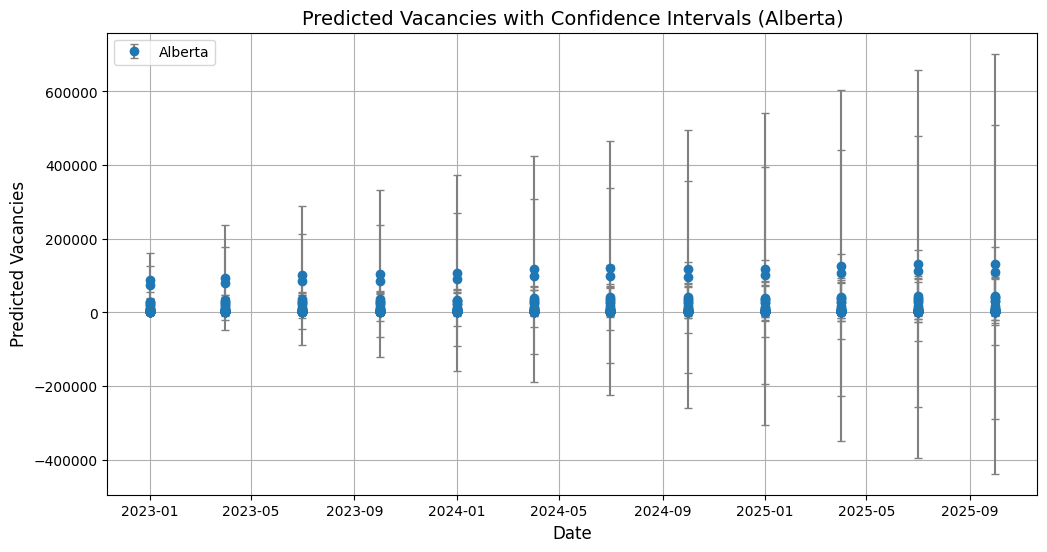

In [42]:
# Visualization 3: Error bars for predictions with confidence intervals
plt.figure(figsize=(12, 6))
subset = predictions_df[predictions_df['geo'] == 'Alberta']  # Focus on one location for clarity
plt.errorbar(subset['ref_date'], subset['predicted_total_vacancies'],
             yerr=[subset['predicted_total_vacancies'] - subset['prediction_lower_bound'],
                   subset['prediction_upper_bound'] - subset['predicted_total_vacancies']],
             fmt='o', ecolor='gray', capsize=3, label='Alberta')

plt.title('Predicted Vacancies with Confidence Intervals (Alberta)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Predicted Vacancies', fontsize=12)
plt.legend()
plt.grid()
plt.show()


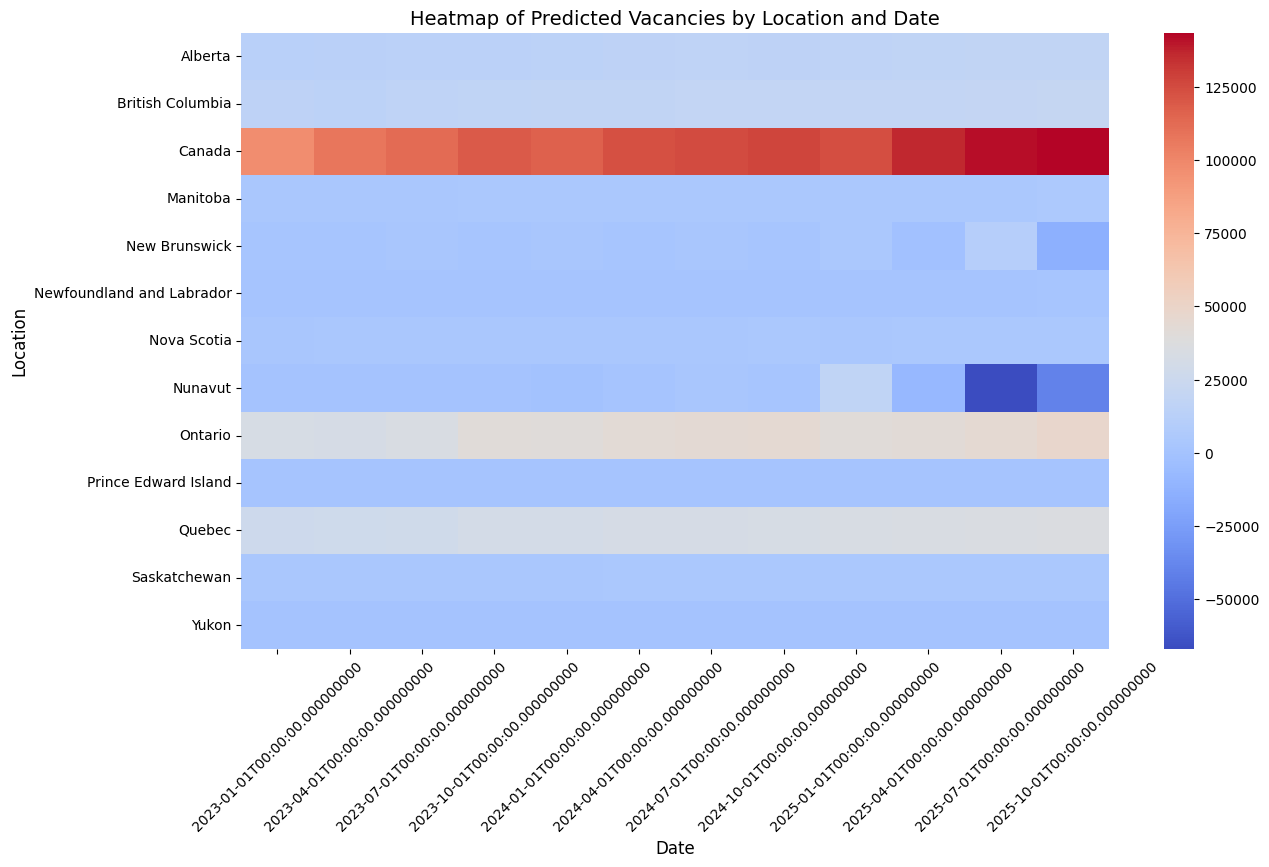

In [43]:
# Visualization 4: Heatmap of vacancies by location and date
pivot_table = predictions_df.pivot_table(values='predicted_total_vacancies',
                                         index='geo', columns='ref_date', aggfunc='mean')
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, cmap='coolwarm', annot=False, cbar=True)

plt.title('Heatmap of Predicted Vacancies by Location and Date', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Location', fontsize=12)
plt.xticks(rotation=45)
plt.show()

C:\Users\sanja\AppData\Local\Temp\ipykernel_22552\2649768153.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=predictions_df, x='job_char', y='predicted_total_vacancies', palette='Set2')


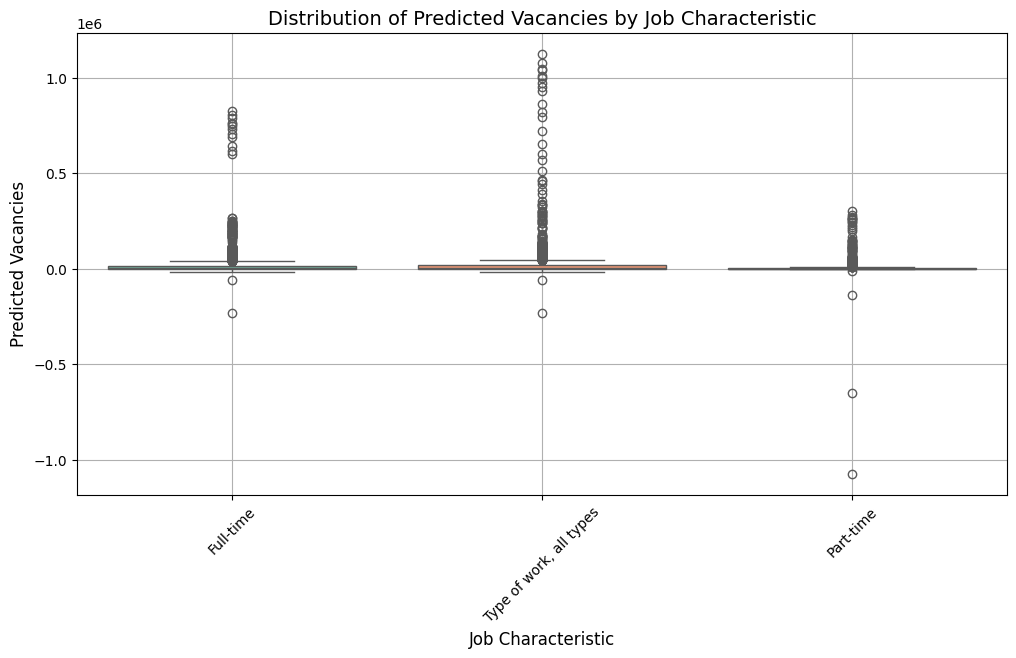

In [44]:
# Visualization 5: Boxplot of predictions for job characteristics
plt.figure(figsize=(12, 6))
sns.boxplot(data=predictions_df, x='job_char', y='predicted_total_vacancies', palette='Set2')

plt.title('Distribution of Predicted Vacancies by Job Characteristic', fontsize=14)
plt.xlabel('Job Characteristic', fontsize=12)
plt.ylabel('Predicted Vacancies', fontsize=12)
plt.xticks(rotation=45)
plt.grid()
plt.show()